In [1]:
import sys
!{sys.executable} -m pip install contractions
!pip install datasets
!pip install evaluate
!pip install fsspec==2023.9.2

!pip install spacy
!python -m spacy download es_core_news_md

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform


⚙️ **Requerimientos importantes sobre el ejercicio**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.



## Imports

In [2]:
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Add your imports here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import contractions
from tqdm.autonotebook import tqdm
tqdm.pandas()

/tmp/ipython-input-3-1469608660.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# 🔍 Ejercicio1: Detección de profesiones en tweets

## Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

Para simplificar el ejercicio, he preparado una versión reducida del dataset original. Tu tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




✅ **Objetivos del ejercicio**

A lo largo de este notebook, completarás las siguientes etapas para construir un clasificador de menciones a profesiones en tweets:

1. **Análisis Exploratorio de Datos (EDA)**: Calcular estadísticas básicas del conjunto de datos (como el número de ejemplos del training set, la distribución de clases del dataset, la longitud media de los textos) o crear visualizaciones para cmprender mejor el contenido de los documentos usando wordclouds o histogramas.

2. **Selección y justificación del modelo**: Elegir un modelo del Hub de Huggingface adecuado para los datos con los que se va a trabajar y el tipo de tarea a desarrollar.

3. **Entrenamiento del clasificador**: Entrenar el modelo de forma reproducible y evaluar su rendimiento sobreel conjunto de datos de validación, incluyendo un classification score y matriz de confusion

4. **Generación de predicciones sobre el conjunte de test**: Aplicar el modelo entrenado al conjunto de test, y guardar las predicciones en un archivo `.tsv` de 2 columnas `id` y `label` separadas por tabulador

📝 **Criterios de Evaluación**

Tu trabajo será evaluado según los siguientes criterios:

| Criterio                                            | Peso  |
|-----------------------------------------------------|--------|
| 🔍 Análisis exploratorio y preprocesamiento         | 20%   |
| 🤖 Selección y justificación del modelo             | 25%   |
| 📁 Formato y validez del archivo de predicciones    | 5%    |
| ⚙️ Ejecución correcta del notebook (sin intervención) | 10%   |
| 📈 Rendimiento del modelo sobre el conjunto de test | 30%   |
| ✍️ Claridad y calidad de las explicaciones          | 10%   |



🔔 **Nota importante:**

> El rendimiento del modelo se evaluará utilizando métricas estándar como el **F1-score** sobre el conjunto de test.

> El archivo de predicciones debe respetar **estrictamente** el formato solicitado (`id` y `label`, separados por tabulador y con extensión `.tsv`).  
  ❗ Si el archivo no cumple con este formato, **el ejercicio no podrá ser evaluado en esa sección**.

> El/la estudiante con el **mayor F1-score** obtendrá la puntuación máxima en el apartado de rendimiento. El resto de calificaciones se ajustarán de forma proporcional al mejor resultado



⚙️ **Requerimientos y reglas**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.


# Tu resolución (rellena las celdas marcadas)

## Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [4]:
#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/1001 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/2786 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/999 [00:00<?, ? examples/s]

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamos cada subset a un pandas dataframe para mayor comodidad.

In [5]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

**Número de documentos**

Obten con la función `get_num_docs_evaluation()` el número de documentos del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [6]:
# Para evitar errores CUDA
dataset_test_df['label'] = 1

In [7]:
dataset_train_df.to_csv('train.csv', index=False)
dataset_test_df.to_csv('test.csv', index=False)
dataset_val_df.head()
# dataset_test_df.head()
#dataset_train_df[dataset_train_df['tweet_id'] == '1289869622187945984']

,tweet_id,text,label
0,1289869622187945984,Entró a trabajar a una residencia de ancianos ...,1
1,1247996977587109888,"600 muertos después , Suecia mantiene su estra...",0
2,1253019627183104000,@AUGC_Comunica Sra. Directora @guardiacivil @M...,1
3,1251069108629749762,"Se me ocurrió de repente , al ver la poca tras...",1
4,1262400218227789825,".@AlmeidaPP _ , ese miserable que no se mereci...",0


In [8]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def get_num_docs_evaluation(dataset_df):
  # Modifica la función.
  num_docs = len(dataset_df)

  # Si se quiere obtener únicamente los que tienen textos distintos de vacío
  # num_docs = len(dataset_df[~dataset_df['text'].isna()])

  # No modifiques el return
  return num_docs


Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [9]:
# Aplica la función
print(f"El numero de documentos en TRAIN son: {get_num_docs_evaluation(dataset_train_df)}")
print(f"El numero de documentos en VALIDATION son: {get_num_docs_evaluation(dataset_val_df)}")


El numero de documentos en TRAIN son: 2786
El numero de documentos en VALIDATION son: 999


**Número de documentos duplicados**

Obten con la función `detect_duplicates_evaluation()` el número de documentos duplicados del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [10]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def detect_duplicates_evaluation(dataset_df):
  # Modifica la función.

  num_duplicates = dataset_df.duplicated(subset='text').sum()
  # No modifiques el return
  return num_duplicates

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [11]:
# Aplica la función
print(f"El número de documentos duplicados en TRAIN son: {detect_duplicates_evaluation(dataset_train_df)}")
print(f"El número de documentos duplicados en VALIDATION son: {detect_duplicates_evaluation(dataset_val_df)}")

El número de documentos duplicados en TRAIN son: 0
El número de documentos duplicados en VALIDATION son: 0


**Número de documentos por cada clase:**


Obten con la función `analyse_num_labels_evaluation()` para calcular el número de documentos de cada categoría en el dataset

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [12]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def analyse_num_labels_evaluation(dataset_df):
  # Modifica la función.
  num_positives = len(dataset_df[dataset_df['label'] == 1])
  num_negatives = len(dataset_df[dataset_df['label'] == 0])

  # No modifiques el return
  return num_positives, num_negatives

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [13]:
# Aplica la función
num_train_positives, num_train_negatives = analyse_num_labels_evaluation(dataset_train_df)
num_val_positives, num_val_negatives = analyse_num_labels_evaluation(dataset_val_df)

print(f"El número de documentos en TRAIN que son positivos son: {num_train_positives} y negativos son: {num_train_negatives}")
print(f"El número de documentos en VALIDATION que son positivos son: {num_val_positives} y negativos son: {num_val_negatives}")


El número de documentos en TRAIN que son positivos son: 1393 y negativos son: 1393
El número de documentos en VALIDATION que son positivos son: 238 y negativos son: 761


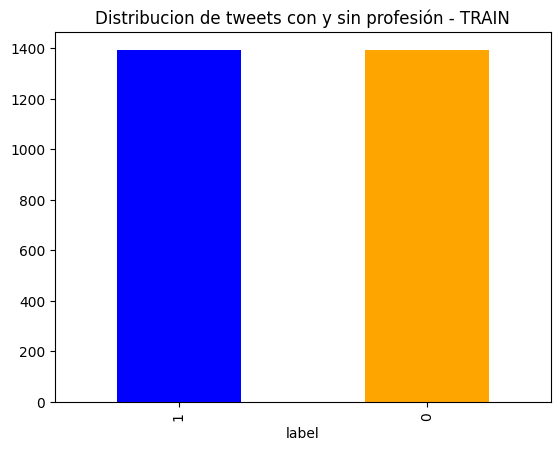

In [14]:
ax, fig = plt.subplots()
etiquetas = dataset_train_df.label.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Distribucion de tweets con y sin profesión - TRAIN')
plt.show()

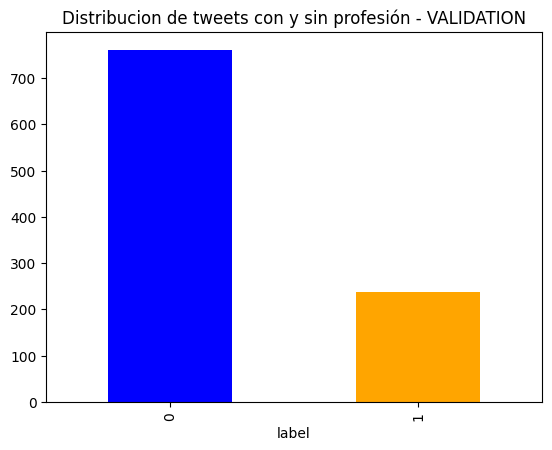

In [15]:
ax, fig = plt.subplots()
etiquetas = dataset_val_df.label.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Distribucion de tweets con y sin profesión - VALIDATION')
plt.show()

> Los datos de entrenamiento están balanceados en sus etiquetas, mientras que en validación están muy desbalanceados

**Distribución de la longitud de los tweet en caracteres:**

<Figure size 1400x1200 with 0 Axes>

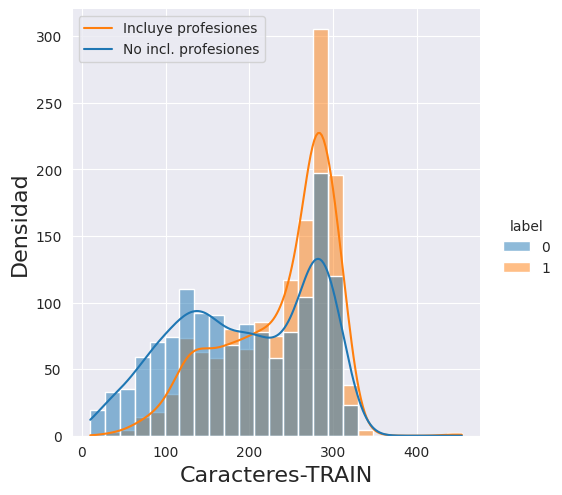

In [16]:
dataset_train_df['char_len'] = dataset_train_df['text'].apply(lambda x: len(x))

# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset_train_df, x="char_len", hue="label", kde=True, legend=True)
plt.legend(["Incluye profesiones", "No incl. profesiones"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres-TRAIN', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

In [17]:
dataset_train_df[dataset_train_df['label'] == 1].describe()

,label,char_len
count,1393.0,1393.000000
mean,1.0,236.663317
std,0.0,64.759120
min,1.0,34.000000
25%,1.0,190.000000
50%,1.0,259.000000
75%,1.0,285.000000
max,1.0,454.000000


In [18]:
dataset_train_df[dataset_train_df['label'] == 0].describe()

,label,char_len
count,1393.0,1393.000000
mean,0.0,193.451543
std,0.0,82.383229
min,0.0,10.000000
25%,0.0,127.000000
50%,0.0,198.000000
75%,0.0,274.000000
max,0.0,321.000000


> Aquí se observa que los tweets que contienen profesiones tienen a ser más largos que los que no contienen. En el caso de los que si contientienen profesiones, el son en promedio más grandes que los que no los contienen en un 22.36% de longuitud. El tweet mas largo es de 454 (Con profesión) y el mas corto es 10 caracteres(sin profesión). En general los textos donde se mencionan profesiones son mucho más grandes que los que no los incluyen.

<Figure size 1400x1200 with 0 Axes>

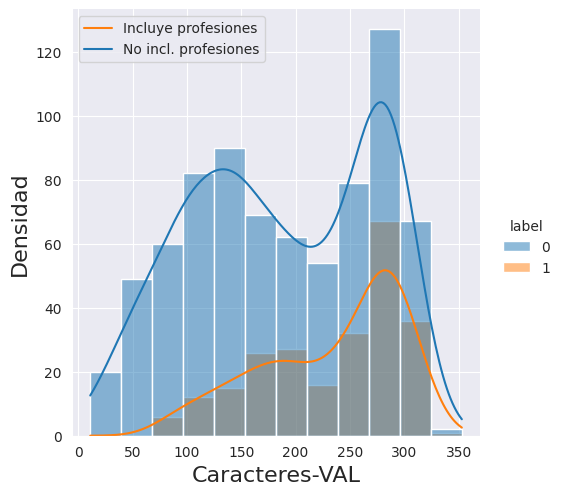

In [19]:
dataset_val_df['char_len'] = dataset_val_df['text'].apply(lambda x: len(x))

# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset_val_df, x="char_len", hue="label", kde=True, legend=True)
plt.legend(["Incluye profesiones", "No incl. profesiones"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres-VAL', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

In [20]:
dataset_val_df.describe()

,label,char_len
count,999.000000,999.000000
mean,0.238238,198.391391
std,0.426219,81.782717
min,0.000000,11.000000
25%,0.000000,132.500000
50%,0.000000,204.000000
75%,0.000000,277.000000
max,1.000000,353.000000


**Análisis de contenido de los tweets**

Para ello utiliza wordclouds

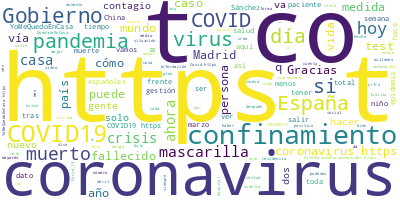

In [21]:
from wordcloud import WordCloud
txt_cat0 = ",".join(dataset_train_df[dataset_train_df['label'] == 0]['text'].to_list())
txt_cat1 = ",".join(dataset_train_df[dataset_train_df['label'] == 1]['text'].to_list())

from nltk.corpus import stopwords
es_stopwords = set(stopwords.words('spanish'))

wordcloud = WordCloud(background_color='white',
                      max_words=5000,
                      contour_width=0,
                      contour_color='plasma',
                      stopwords=es_stopwords,
                      normalize_plurals=True)

wordcloud.generate(txt_cat0)
wordcloud.to_image()

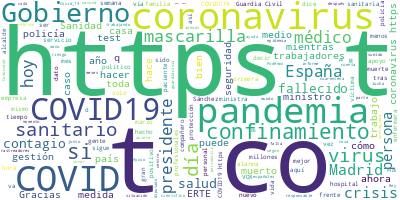

In [22]:
wordcloud.generate(txt_cat1)
wordcloud.to_image()

> Se observar palabras clave como Coronavirus, Gobierno, Pandemia. Pero hay un gran presencia de textos a referencias. Después de la tokenización y limpieza se podría observar mejor lo que indica. Sin embargo es claro que en el caso donde no se meciona las profesiones, la idea clara es la presencia del virus y el confinaimiento. Mientras que en el caso de donde se menciona la profesion, la palabra sanitario, pandemia y gobierno está representadas con mayor tamaño.

In [23]:
# SOLO PARA TRAINING
# Utilizando el procedimiento que vimos en clase para limpiar mejor los datasets
# y observar mejor el contenido - Solo para analisis exploratorio

# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

def replace_contraction(text):
  return contractions.fix(text, slang=True)

# Tokenizador
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(documento):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

# Lematizar
import spacy
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])
# es_core_news_md -> idioma español

def lematizar_eliminacion_tokens(texto):
    # Procesar el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizar el texto
    lemas = [token.lemma_ for token in doc]

    # Eliminar símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in es_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado


In [24]:
dataset_train_df['normalized'] = dataset_train_df['text'].progress_apply(lambda x: eliminar_espacios(x))
dataset_train_df['normalized'] = dataset_train_df['normalized'].progress_apply(lambda x: texto_to_lower(x))
dataset_train_df['normalized'] = dataset_train_df['normalized'].progress_apply(lambda x: replace_contraction(x))
dataset_train_df['normalized'] = dataset_train_df['normalized'].progress_apply(lambda x: normalizar_tokens(x))
dataset_train_df['normalized'] = dataset_train_df['normalized'].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

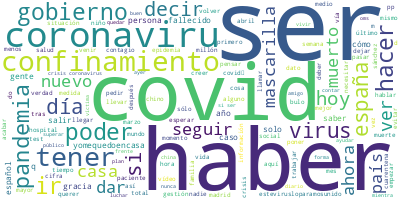

In [25]:
txt_cat_norm0 = ",".join(dataset_train_df[dataset_train_df['label'] == 0]['normalized'].to_list())
txt_cat_norm1 = ",".join(dataset_train_df[dataset_train_df['label'] == 1]['normalized'].to_list())

# Para eliminar el ruido creadas en la depuración
es_stopwords.update(["URL", "MENTION", "NUM"])

wordcloud.generate(txt_cat_norm0)
wordcloud.to_image()

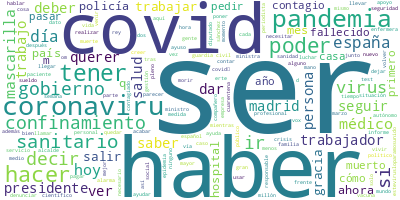

In [26]:
wordcloud.generate(txt_cat_norm1)
wordcloud.to_image()

> Una vez limpio el texto, se puede mirar un poco mejor los textos de los tweets. Sin embargo, en la categoria que no tienen profesion, las palabras que vas se destacan son confinamiento, coronavirus y pandemia.
Para el caso donde se menciona la profesion, es covid, pandemia, poder.

## Tokenización

El texto del dataset no está preparado para ser introducido en un modelo Transformers. Lleva a cabo el proceso de tokenización.

In [27]:
# IMPORTS



In [28]:
dataset_test_df.head()

,tweet_id,text,label
0,1277969650051997701,Esto es vergonzoso : una limpiadora de un hosp...,1
1,1263161378627600385,@el_pais No quiero ni imaginarme como hubieran...,1
2,1255919996779315208,Fernando Simón reconoce que Madrid y Cataluña ...,1
3,1282361712117780486,PSOE y Podemos me subieron el salario mínimo d...,1
4,1267872916009615364,"Malditos Cayetanos ! ! ! Míralos , saltándose ...",1


Selecciona un modelo apropiado para la tarea:

> Recuerda que en la siguiente celda sólo debes asignar un valor a model_name. No añadas más información en la celda.

In [29]:
#NO-MODIFY: VARIABLE NAME
model_name = "Twitter/twhin-bert-base"

> El segundo modelo que seleccion fue el de Twitter/twhin-bert-base que tiene soporte para multilenguage y es de bajo tamaño (280 mb), mucho más pequeño que el de Facebook.
Las razones principales son desempeño, porque el entrenamiento fue mucho más rápido(menos de 10 min), mientras que el de facebook era por lo menos 20 min y está adaptado para trabajar con tweets.
Fuente: https://huggingface.co/Twitter/twhin-bert-base

> NOTA: Originalmente tome el modelo de Facebook,pero era muy pesado y los resultados no eran mejores que el modelo de twitter. Esta era el texto original de mi justificacion para el modelo inicial. Luego cambié al modelo de Twitter. (Texto original del primero modelo probado >>)El modelo seleccionado es el FacebookAI/xlm-roberta-base.
Este modelo tiene una gran cantidad des descargas (13,501,854 en el último mes), es multilenguage (por lo que español está incluido), es creado por Facebook (una companía de importancia en la industria), y tiene mucha informacion de soporte.
Fuente:
https://huggingface.co/FacebookAI/xlm-roberta-base

Puedes continuar con el proceso aquí:

In [30]:
from datasets import Dataset, DatasetDict, ClassLabel
dataset_train_hf = Dataset.from_pandas(dataset_train_df)#.rename_column("label", "labels")
dataset_val_hf = Dataset.from_pandas(dataset_val_df)#.rename_column("label", "labels")
dataset_test_hf = Dataset.from_pandas(dataset_test_df)#.rename_column("label", "labels")



In [31]:
dataset_train_hf = dataset_train_hf.cast_column("label", ClassLabel(num_classes=2)) # 0,1

Casting the dataset:   0%|          | 0/2786 [00:00<?, ? examples/s]

In [32]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    # Tokenizar el texto
    return tokenizer(examples['text'], padding="max_length", truncation=True)

dataset_train_hf = dataset_train_hf.map(preprocess_function, batched=True)
dataset_val_hf = dataset_val_hf.map(preprocess_function, batched=True)
dataset_test_hf = dataset_test_hf.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/2786 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

## Fine-tuning

Carga el model para ser ajustado posteriormente:

In [33]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "NO_INCL_PROFESION", 1: "INCL_PROFESION"}
label2id = {"NO_INCL_PROFESION": 0, "INCL_PROFESION": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=2, id2label=id2label, label2id=label2id)


config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Configuracion training_args

Configura los parámetros de entrenamiento del modelo.


>

> Recuerda que en la siguiente celda sólo debes asignar atributos a la variable training_args. No añadas  otras variables en la celda

In [34]:
#NO-MODIFY: VARIABLE NAME
training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.1,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=52
)

### Métricas de evaluación

Define las métricas de evaluación

In [35]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)["f1"]

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }


### Ajuste del modelo

Lleva a cabo el ajuste del modelo:

In [36]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train_hf,
    eval_dataset=dataset_val_hf,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # con 3 patience tiene mejores resultados
)

/tmp/ipython-input-36-690076376.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


> Se probó con early stop de 2 y 3. El modelo tiene mejores resultados con el parámetro ajustado a 3.

In [37]:
trainer.train()

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Step,Training Loss,Validation Loss,Accuracy,F1 Score
50,0.661800,0.636559,0.647648,0.552163
100,0.476900,0.395433,0.841842,0.738411
150,0.297500,0.261378,0.906907,0.831826
200,0.217800,0.349041,0.914915,0.844607
250,0.217400,0.245626,0.928929,0.863724
300,0.204600,0.414502,0.881882,0.797251
350,0.228200,0.214798,0.929930,0.864341
400,0.138300,0.410838,0.886887,0.804836
450,0.126300,0.234848,0.934935,0.873294
500,0.124700,0.270856,0.934935,0.874759


TrainOutput(global_step=500, training_loss=0.2693487691879273, metrics={'train_runtime': 277.9989, 'train_samples_per_second': 40.086, 'train_steps_per_second': 2.518, 'total_flos': 415097773155240.0, 'train_loss': 0.2693487691879273, 'epoch': 2.857142857142857})

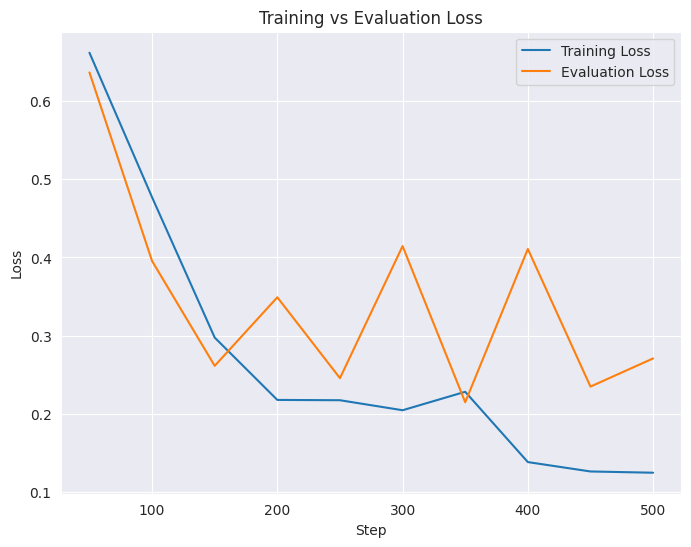

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraemos los logs de entrenamiento
history = pd.DataFrame(trainer.state.log_history)

# A veces los logs pueden tener pasos donde no se evalúa. Filtramos filas con 'loss' y 'eval_loss'
train_loss = history[history['loss'].notna()][['step', 'loss']]
eval_loss = history[history['eval_loss'].notna()][['step', 'eval_loss']]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
trainer.save_model("output_model_save")

## Evaluacion

Una vez llevada a cabo el entrenamiento, realiza la evaluación del modelo.

In [40]:
dataset_train_hf

Dataset({
    features: ['tweet_id', 'text', 'label', 'char_len', 'normalized', 'input_ids', 'attention_mask'],
    num_rows: 2786
})

In [41]:
trainer.evaluate(dataset_val_hf)

{'eval_loss': 0.27085620164871216,
 'eval_accuracy': 0.934934934934935,
 'eval_f1_score': 0.8747591522157996,
 'eval_runtime': 6.0078,
 'eval_samples_per_second': 166.285,
 'eval_steps_per_second': 10.486,
 'epoch': 2.857142857142857}

In [42]:
predictions = trainer.predict(dataset_val_hf)

In [43]:
dataset_val_hf

Dataset({
    features: ['tweet_id', 'text', 'label', 'char_len', 'input_ids', 'attention_mask'],
    num_rows: 999
})

In [44]:
y_pred = predictions.predictions.argmax(axis=1)
y_true = [x["label"] for x in dataset_val_hf]

In [45]:
y_true[:10]

[1, 0, 1, 1, 0, 0, 0, 0, 0, 1]

In [46]:
y_pred[:10]

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1])

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[707  54]
 [ 11 227]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       761
           1       0.81      0.95      0.87       238

    accuracy                           0.93       999
   macro avg       0.90      0.94      0.92       999
weighted avg       0.94      0.93      0.94       999



> Obtenemos un score F1 para cuando no tienen profesion del 0.96 y de 0.88 cuando tienen profesion. Es modelo que funciona bastante bien identificando cuando no tiene profesion. Contrastado con el dataset de validación (que está muy desbalanceado)

## Genera predicciones

Genera predicciones sobre el test set. Recuerda que el archivo que generes y adjuntes al ejercicio debe tener dos columnas:


| id         | label |
|------------|-------|
| 1234567890 | 1     |
| 1234567891 | 0     |
| 1234567892 | 0     |
| 1234567893 | 1     |

- El archivo debe estar en formato **TSV** (separado por tabuladores).
- Debe contener exactamente **dos columnas**: `id` y `label`.
- Es obligatorio incluir la **cabecera**.


In [48]:
from transformers import pipeline
import os

modelo_clasificacion = pipeline("text-classification", model='/content/output_model_save', tokenizer=model_name)


Device set to use cuda:0


In [49]:
label2id = {"NO_INCL_PROFESION": 0, "INCL_PROFESION": 1}

#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")


In [50]:
x_id = [x["tweet_id"] for x in dataset_test_hf]
documentos = [x["text"] for x in dataset_test_hf]

In [51]:
from tqdm import tqdm
import torch
batch_size = 32
preds = []

for i in tqdm(range(0, len(documentos), batch_size)):
    batch = documentos[i:i+batch_size]
    with torch.no_grad():
        batch_preds = modelo_clasificacion(batch)
    preds.extend(batch_preds)

100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


In [52]:
num_preds = [label2id[x["label"]] for x in preds]

In [53]:
import pandas as pd
output_df2 = pd.DataFrame(
    {'id': x_id,
     'label': num_preds
    })

In [54]:
output_df2.head(10)

,id,label
0,1277969650051997701,1
1,1263161378627600385,0
2,1255919996779315208,0
3,1282361712117780486,0
4,1267872916009615364,0
5,1286821839461851138,1
6,1242831505539444739,0
7,1245273112305971200,0
8,1250159489598324744,0
9,1283375865003474944,0


In [55]:
output_df2.to_csv("NARVAEZ_BARREIROS_IVAN_RICARDO_ejercicio1_predicciones.tsv", sep="\t",index=False)